In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications.efficientnet import EfficientNetB0 as EfficientNet
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
img_height = 224
img_width = 224
batch_size = 256

In [3]:
from pathlib import Path
import imghdr
import shutil
from os import remove

destination_folder_path = '/Volumes/SSD_ANDRÉS/Espectrogramas/descartados'
data_dir = "/Volumes/SSD_ANDRÉS/Espectrogramas/off/ns=32_sol=0.9_lowpass_f=0-1"
image_extensions = [".png", ".jpg", 'bmp', 'jpeg']  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
contador = 0
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        destination_file_path = os.path.join(destination_folder_path, f'/im{contador}')
        if img_type is None:
            print(f"{filepath} is not an image")
            remove(filepath)
            #shutil.move(filepath, destination_file_path)
            contador += 1
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            remove(filepath)
            #shutil.move(filepath, destination_file_path)
            contador += 1

In [4]:
train_directory = "/Volumes/SSD_ANDRÉS/Espectrogramas/off/ns=32_sol=0.9_lowpass_f=0-1"

In [5]:
# Dividir el set en entrenamiento y validación
train_ds, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', batch_size=batch_size, image_size=(img_height, img_width), seed=123, 
    validation_split=0.2, subset='both')

Found 6015 files belonging to 3 classes.
Using 4812 files for training.
Using 1203 files for validation.


2024-03-17 22:22:48.315514: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-17 22:22:48.315537: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-17 22:22:48.315540: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-17 22:22:48.315564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-17 22:22:48.315583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
test_directory = "/Volumes/SSD_ANDRÉS/Espectrogramas/pb1test"
test_ds= tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', batch_size=batch_size, image_size=(img_height, img_width), seed=123)

Found 8886 files belonging to 3 classes.


In [7]:
# Esta parte se usa para generar datos para pruebas. Si se tienen datos específicos para las pruebas, se deben llamar con el nombre de test_ds
'''num_elements = len(train_ds)

porcentaje_test = 0.1
train_size = int((1-porcentaje_test) * num_elements)


test_size = num_elements - train_size
test_ds = train_ds.take(test_size)
train_ds = train_ds.skip(test_size)'''

'num_elements = len(train_ds)\n\nporcentaje_test = 0.1\ntrain_size = int((1-porcentaje_test) * num_elements)\n\n\ntest_size = num_elements - train_size\ntest_ds = train_ds.take(test_size)\ntrain_ds = train_ds.skip(test_size)'

In [8]:
class_names = train_ds.class_names
print(class_names)

['LP', 'VLP', 'VT']


In [9]:
'''y_train = train_ds.map(lambda _, label: label).unbatch()
y_train = list(y_train.as_numpy_iterator())
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)'''

"y_train = train_ds.map(lambda _, label: label).unbatch()\ny_train = list(y_train.as_numpy_iterator())\nclass_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)\nclass_weight_dict = dict(enumerate(class_weights))\nprint(class_weight_dict)"

# Modelo DenseNet 121

In [10]:
num_classes = len(class_names)

In [11]:
# Cargar la arquitectura preentrenada VGG16 sin las capas superiores (sin incluir la capa de salida)
base_model = EfficientNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) #input_shape=(altura, anchura, canales))
base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

In [12]:
# Congelar las capas de la base (no se entrenarán durante el ajuste fino)
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Agregar capas personalizadas a la arquitectura base
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.000001), activity_regularizer=regularizers.L2(0.000001)),
    #layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [14]:
# Definir la programación de la tasa de aprendizaje exponencial
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=len(train_ds)*20,
    decay_rate=0.9
)

In [15]:
# Crear un optimizador con la programación de la tasa de aprendizaje exponencial y momentum
custom_optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

In [16]:
# Compilar el modelo
model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Entrenar el modelo
epochs = 100

history = model.fit(train_ds, epochs=epochs, validation_data=validation_dataset)#, class_weight=class_weight_dict)

Epoch 1/100


2024-03-17 22:22:51.735792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 1.8874 - accuracy: 0.4701

2024-03-17 22:23:32.180575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 52s 3s/step - loss: 1.8874 - accuracy: 0.4701 - val_loss: 0.4320 - val_accuracy: 0.8188
Epoch 2/100
19/19 [==============================] - 49s 3s/step - loss: 0.4761 - accuracy: 0.8123 - val_loss: 0.2373 - val_accuracy: 0.9152
Epoch 3/100
19/19 [==============================] - 49s 3s/step - loss: 0.2724 - accuracy: 0.8969 - val_loss: 0.1879 - val_accuracy: 0.9435
Epoch 4/100
19/19 [==============================] - 48s 2s/step - loss: 0.2171 - accuracy: 0.9266 - val_loss: 0.1498 - val_accuracy: 0.9643
Epoch 5/100
19/19 [==============================] - 47s 2s/step - loss: 0.1898 - accuracy: 0.9408 - val_loss: 0.1397 - val_accuracy: 0.9709
Epoch 6/100
19/19 [==============================] - 49s 3s/step - loss: 0.1773 - accuracy: 0.9458 - val_loss: 0.1375 - val_accuracy: 0.9651
Epoch 7/100
19/19 [==============================] - 49s 3s/step - loss: 0.1647 - accuracy: 0.9456 - val_loss: 0.1277 - val_accuracy: 0.9692
Epoch 8/100
19/19 [======

In [18]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_ds)
print(f'Precisión en el conjunto de prueba: {test_acc}')

35/35 [==============================] - 70s 2s/step - loss: 0.2451 - accuracy: 0.9221
Precisión en el conjunto de prueba: 0.9221246838569641


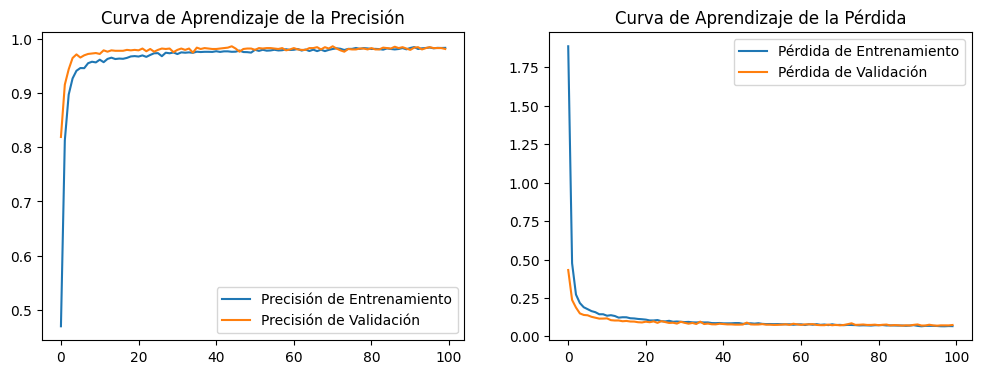

In [19]:
# Trazar la curva de aprendizaje
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Curva de Aprendizaje de la Precisión')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Curva de Aprendizaje de la Pérdida')
plt.show()

In [20]:
ruta_modelos_entrenados = '/Volumes/SSD_ANDRÉS/Modelos entrenados'

In [21]:
model.save(ruta_modelos_entrenados+'/Efficient_01')

INFO:tensorflow:Assets written to: /Volumes/SSD_ANDRÉS/Modelos entrenados/Efficient_01/assets


INFO:tensorflow:Assets written to: /Volumes/SSD_ANDRÉS/Modelos entrenados/Efficient_01/assets


In [22]:
ruta_modelos_entrenados = '/Volumes/SSD_ANDRÉS/Modelos entrenados'
new_model = tf.keras.models.load_model(ruta_modelos_entrenados+'/Efficient_01')
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   #print("Label: ",label_batch)
   y_true.append(label_batch)
   # compute predictions
   #print("Imagen: ",image_batch)
   preds = new_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))
   #print("-----------------")

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2024-03-17 23:44:48.278738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 2s 227ms/step


2024-03-17 23:45:53.076464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 404ms/step


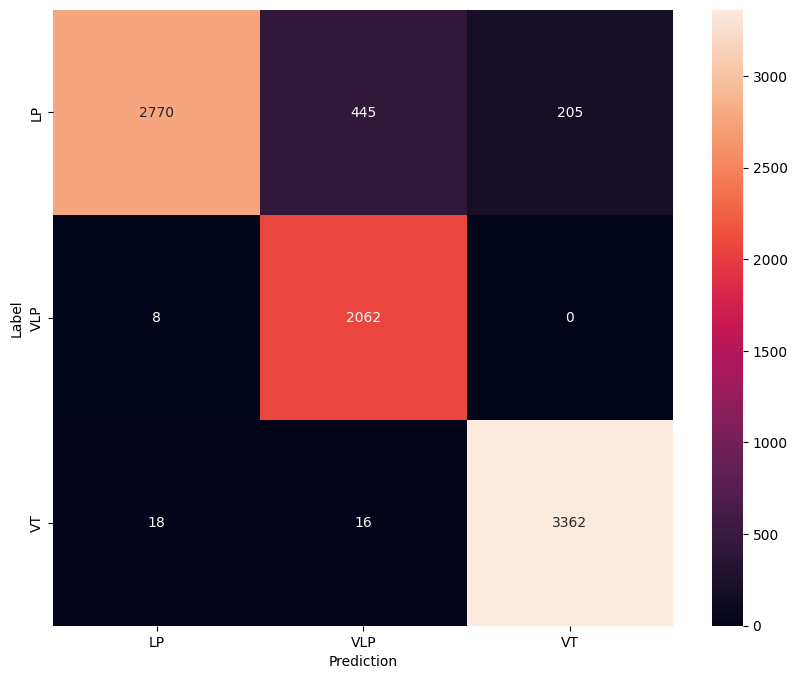

In [23]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [24]:
cm = confusion_matrix(correct_labels, predicted_labels)
print('%LP: '+str(cm[0][0]/sum(cm[0]) * 100))
print('%VLP: '+str(cm[1][1]/sum(cm[1]) * 100))
print('%VT: '+str(cm[2][2]/sum(cm[2]) * 100))

%LP: 80.99415204678363
%VLP: 99.61352657004831
%VT: 98.99882214369848


In [25]:
from sklearn.metrics import classification_report
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      3420
           1       0.82      1.00      0.90      2070
           2       0.94      0.99      0.97      3396

    accuracy                           0.92      8886
   macro avg       0.92      0.93      0.92      8886
weighted avg       0.93      0.92      0.92      8886

